In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=211eade8a514c6355d65174503bd42a49d0b279b034926f43e8f20596eeb54e9
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import pyswarm as ps
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from pyswarm import pso


In [ ]:
# Replace 'your_file.xlsx' with the actual path to your Excel file
df = pd.read_excel('covidjkt.xlsx')

print(df)

    Jakarta Pusat  Jakarta Utara  Jakarta Barat  Jakarta Selatan  \
0              43            129            180              206   
1             178            387            368              337   
2             112            246            301              233   
3             107            211            154              118   
4             175            338            231              171   
5             324            566            474              366   
6             343            499            683              562   
7             304            465            692              502   
8             318            419            557              694   
9             362            530            582              804   
10            400            785            649              918   
11            414            641            576              767   
12            424            631            670              778   
13            238            391            471 

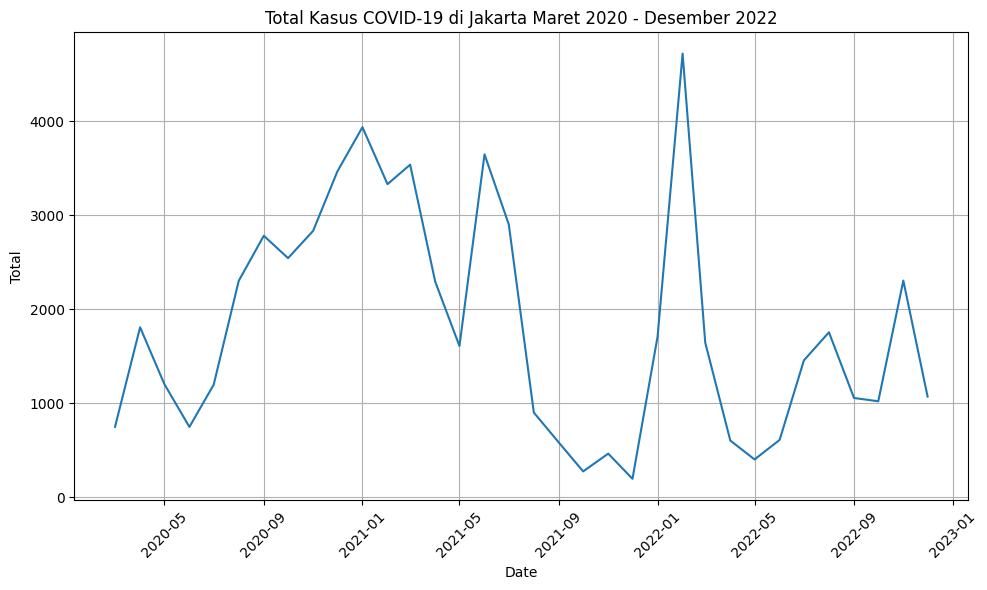

In [ ]:
# Assuming 'Date' and 'Total' are column names in your DataFrame
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime objects if needed

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(df['Date'], df['total'])
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Total Kasus COVID-19 di Jakarta Maret 2020 - Desember 2022')
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

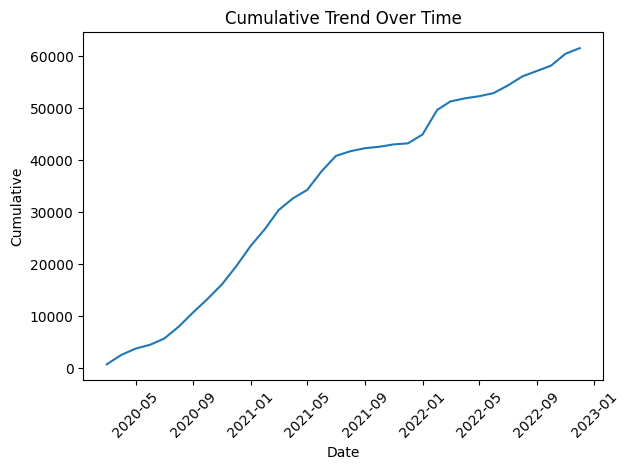

In [ ]:
# Assuming 'Date' is the column name for your date data
# and 'Cumulative' is the column name for your cumulative data
plt.plot(df['Date'], df['cumulative'])
plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

<ipython-input-15-23c40f75aa57>:3: RuntimeWarning: overflow encountered in exp
  return A * (1 + np.exp(-k * (t - t0))) ** (-1 / nu)


Stopping search: maximum iterations reached --> 100
Optimal parameters: A=4501.0, k=0.05322823736865013, t0=23.723973200851983, nu=0.8687069574281209
Root Mean Squared Error (RMSE): 100.96918828237388
Mean Squared Error (MSE): 10194.776982401467


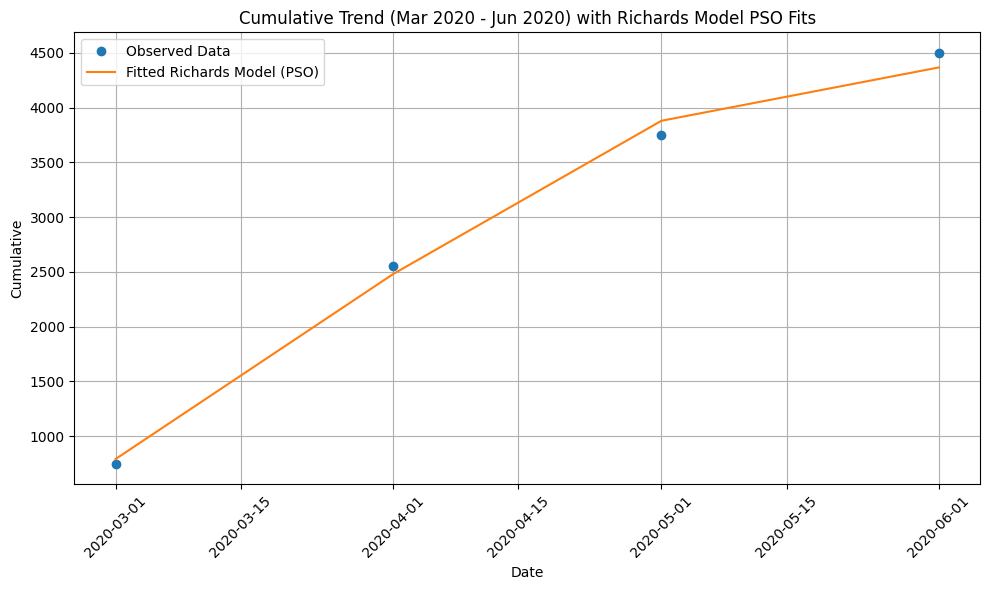

In [ ]:
# Define Richards Model
def richards_model(t, A, k, t0, nu):
    return A * (1 + np.exp(-k * (t - t0))) ** (-1 / nu)
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A, k, t0, nu = params
    y_predicted = richards_model(t, A, k, t0, nu)
    return np.sum((y_observed - y_predicted) ** 2)

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to September 2008
start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2020-06-30')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
lb = [0, 0, min(t_data), 0.01]  # Lower bounds for A, k, t0, nu
ub = [max(y_observed), 10, max(t_data), 5]  # Upper bounds for A, k, t0, nu

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed))

# Output optimal parameters
A_opt, k_opt, t0_opt, nu_opt = params_opt
print(f"Optimal parameters: A={A_opt}, k={k_opt}, t0={t0_opt}, nu={nu_opt}")

# After obtaining the optimal parameters from PSO
A_opt, k_opt, t0_opt, nu_opt = params_opt

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A_opt, k_opt, t0_opt, nu_opt)

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse1 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse1}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse1 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse1}")

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Mar 2020 - Jun 2020) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

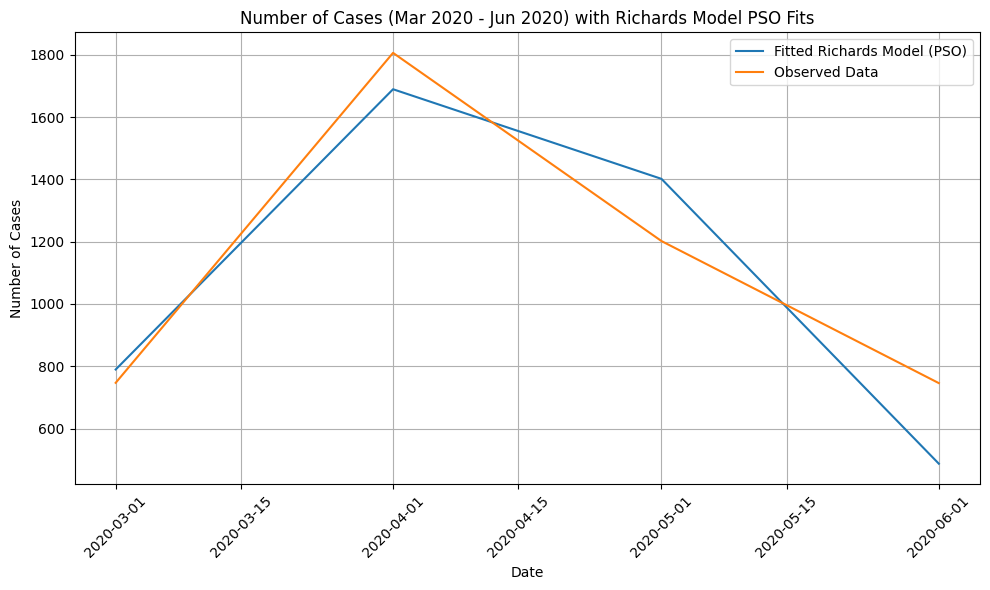

In [ ]:
def richards(t, A1, k1, t01, nu1):
    return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)

y_predicted = richards(t_data, A_opt, k_opt, t0_opt, nu_opt)
ysubs =np.ones(len(y_predicted))
ysubs[0] = y_predicted[0]
for i in range (1,len(y_predicted)) :
  ysubs[i] = y_predicted[i] - y_predicted[i-1]

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], ysubs, '-', label='Fitted Richards Model (PSO)')
plt.plot(filtered_df['Date'], filtered_df['total'], label='Observed Data')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Number of Cases (Mar 2020 - Jun 2020) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-31-de6a26882b2f>:3: RuntimeWarning: overflow encountered in exp
  return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1) + A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)


Stopping search: maximum iterations reached --> 100
Optimal parameters: A1=4501.0, k1=0.05322823736865013, t01=23.723973200851983, nu1=0.8687069574281209, A2=29134.79305961847, k2=0.022333352787628685, t02=306.12143791826486, nu2=1.6905327960889553


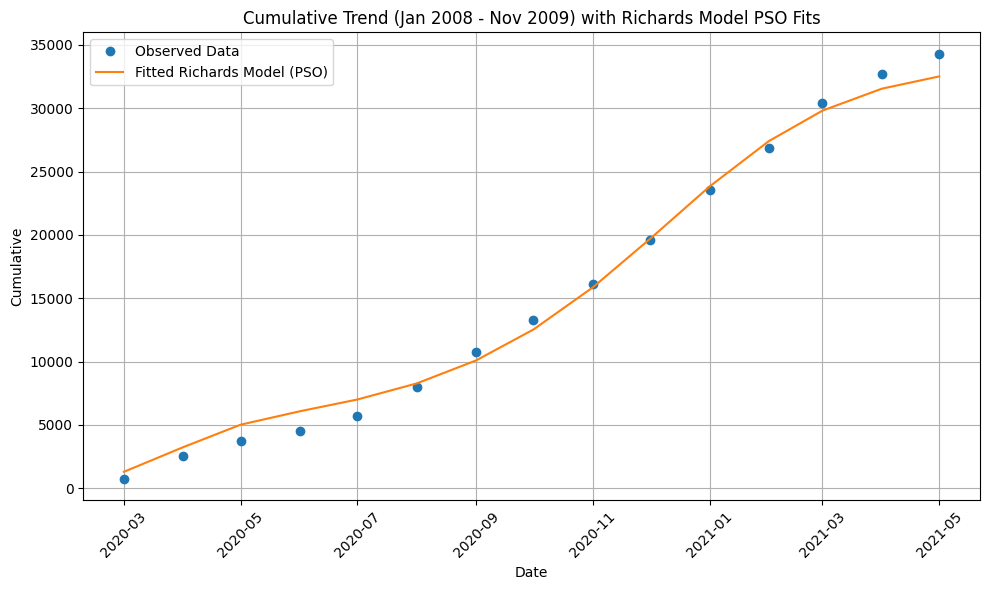

Root Mean Squared Error (RMSE): 937.0943390258723
Mean Squared Error (MSE): 878145.8002343364


In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2):
    return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1) + A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2009
start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2021-05-30')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb = [0, 0, min(t_data), 0.01, 0, 0, min(t_data), 0.01]  # Lower bounds for A1, k1, t01, nu1, A2, k2, t02, nu2
ub = [max(y_observed), 10, max(t_data), 5, max(y_observed), 10, max(t_data), 5]  # Upper bounds for A1, k1, t01, nu1, A2, k2, t02, nu2

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed))

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt = params_opt
print(f"Optimal parameters: A1={A_opt}, k1={k_opt}, t01={t0_opt}, nu1={nu_opt}, A2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A_opt, k_opt, t0_opt, nu_opt, A2_opt, k2_opt, t02_opt, nu2_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Jan 2008 - Nov 2009) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse2 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse2}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse2 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse2}")

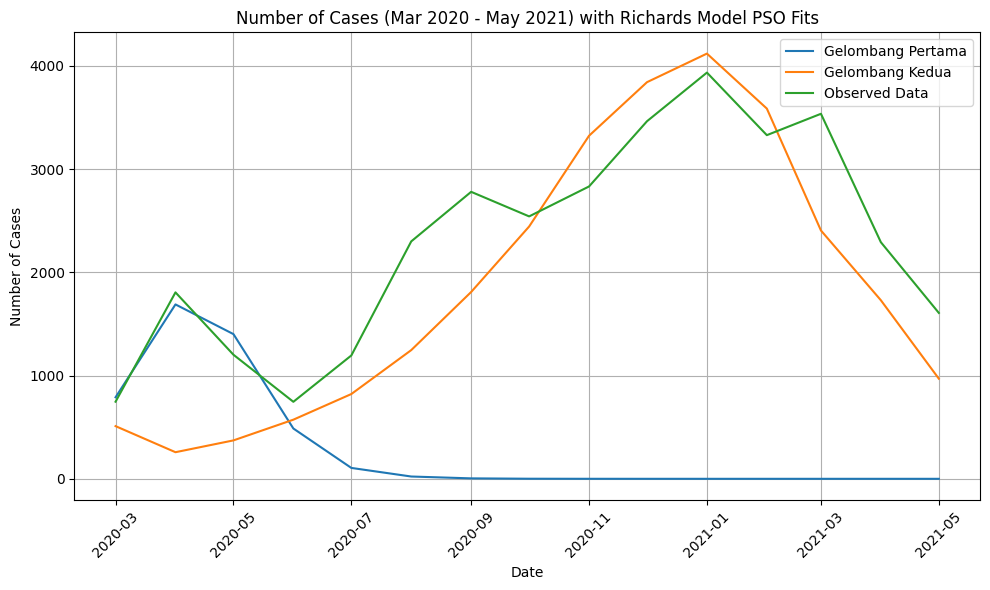

In [ ]:
def richards(t, A1, k1, t01, nu1):
    return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)

y_predicted1 = richards(t_data, A_opt, k_opt, t0_opt, nu_opt)
y_predicted2 = richards(t_data, A2_opt, k2_opt, t02_opt, nu2_opt)
ysubs1 =np.ones(len(y_predicted1))
ysubs2 =np.ones(len(y_predicted2))
ysubs1[0] = y_predicted1[0]
ysubs2[0] = y_predicted2[0]
for i in range (1,len(y_predicted1)) :
  ysubs1[i] = y_predicted1[i] - y_predicted1[i-1]
  ysubs2[i] = y_predicted2[i] - y_predicted2[i-1]

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], ysubs1, '-', label='Gelombang Pertama')
plt.plot(filtered_df['Date'], ysubs2, '-', label='Gelombang Kedua')
plt.plot(filtered_df['Date'], filtered_df['total'], label='Observed Data')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Number of Cases (Mar 2020 - May 2021) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-278-940be5932086>:3: RuntimeWarning: overflow encountered in exp
  return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1) + A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2) + A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)


Stopping search: maximum iterations reached --> 100
Optimal parameters: A1=4500.999999992544, k1=0.05462094612337453, t01=25.064525871771448, nu1=0.9117170823415796, A2=22379.349020676204, k2=0.040662217002685276, t02=324.43090418735187, nu2=2.6782798990329026, A3=8412.664391362632, k3=0.10666169476661837, t03=220.4148378853038, nu3=4.2770918566621585


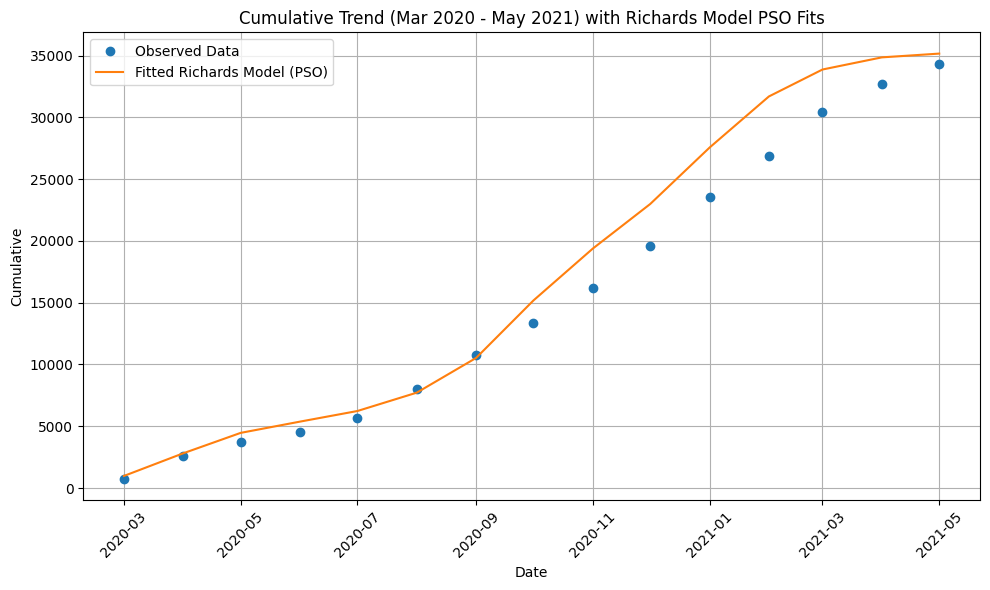

Root Mean Squared Error (RMSE): 2361.321737382764
Mean Squared Error (MSE): 5575840.347436354


In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3):
    return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1) + A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2) + A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2011
start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2021-05-31')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb = [0, 0, min(t_data), 0.01, 0, 0, min(t_data), 0.01, 0, 0, min(t_data), 0.01]  # Lower bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3
ub = [max(y_observed), 10, max(t_data), 5, max(y_observed), 10, max(t_data), 5, max(y_observed), 10, max(t_data), 5]  # Upper bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed), swarmsize = 300)

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2a_opt, k2a_opt, t02a_opt, nu2a_opt, A3_opt, k3_opt, t03_opt, nu3_opt = params_opt
print(f"Optimal parameters: A1={A_opt}, k1={k_opt}, t01={t0_opt}, nu1={nu_opt}, A2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}, A3={A3_opt}, k3={k3_opt}, t03={t03_opt}, nu3={nu3_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A_opt, k_opt, t0_opt, nu_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Mar 2020 - May 2021) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse3 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse3}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse3 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse3}")

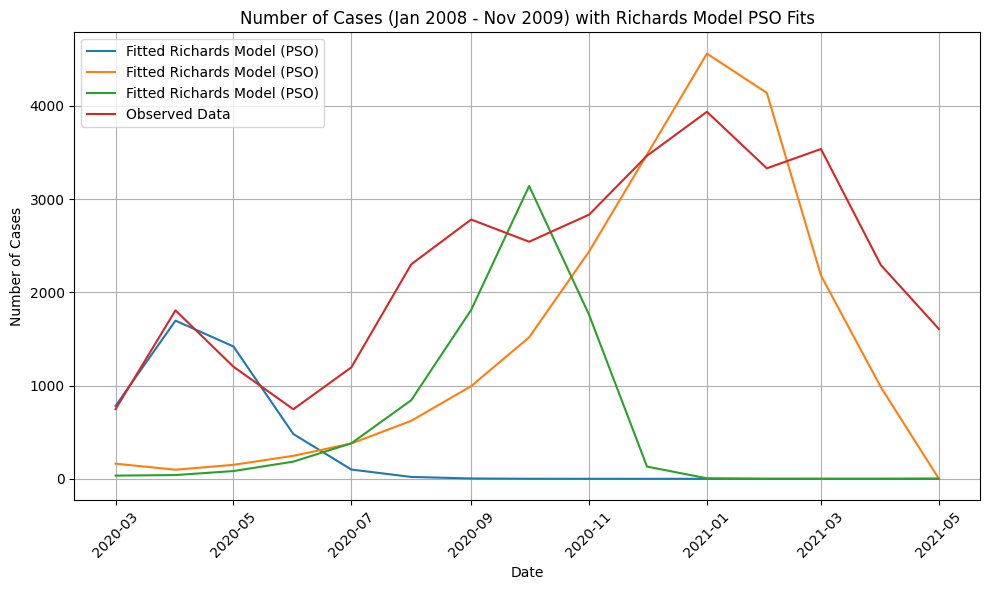

In [ ]:
def richards(t, A1, k1, t01, nu1):
    return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)

A_opt=4500.999999992544
k_opt=0.05462094612337453
t0_opt=25.064525871771448
nu_opt=0.9117170823415796
A2_opt=22379.349020676204
k2_opt=0.040662217002685276
t02_opt=324.43090418735187
nu2_opt=2.6782798990329026
A3_opt=8412.664391362632
k3_opt=0.10666169476661837
t03_opt=220.4148378853038
nu3_opt=4.2770918566621585

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2011
start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2021-05-31')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

y_predicted1 = richards(t_data, A_opt, k_opt, t0_opt, nu_opt)
y_predicted2 = richards(t_data, A2_opt, k2_opt, t02_opt, nu2_opt)
y_predicted3 = richards(t_data, A3_opt, k3_opt, t03_opt, nu3_opt)
ysubs1 =np.ones(len(y_predicted1))
ysubs2 =np.ones(len(y_predicted2))
ysubs3 =np.ones(len(y_predicted3))
ysubs1[0] = y_predicted1[0]
ysubs2[0] = y_predicted2[0]
ysubs3[0] = y_predicted3[0]

for i in range (1,len(y_predicted1)-1) :
  ysubs1[i] = y_predicted1[i] - y_predicted1[i-1]
  ysubs2[i] = y_predicted2[i] - y_predicted2[i-1]
  ysubs3[i] = y_predicted3[i] - y_predicted3[i-1]

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], ysubs1, '-', label='Fitted Richards Model (PSO)')
plt.plot(filtered_df['Date'], ysubs2, '-', label='Fitted Richards Model (PSO)')
plt.plot(filtered_df['Date'], ysubs3, '-', label='Fitted Richards Model (PSO)')
plt.plot(filtered_df['Date'], filtered_df['total'], label='Observed Data')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Number of Cases (Jan 2008 - Nov 2009) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-351-db9e81bb39f3>:3: RuntimeWarning: overflow encountered in exp
  return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1) + A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2) + A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)


Stopping search: maximum iterations reached --> 100
Optimal parameters: A1=4500.999999992544, k1=0.05462094612337453, t01=25.064525871771448, nu1=0.9117170823415796, A2=22379.349020676204, k2=0.040662217002685276, t02=324.43090418735187, nu2=2.6782798990329026, A3=16512.479489434023, k3=0.018328563846103315, t03=375.74358530544197, nu3=0.530782248001272


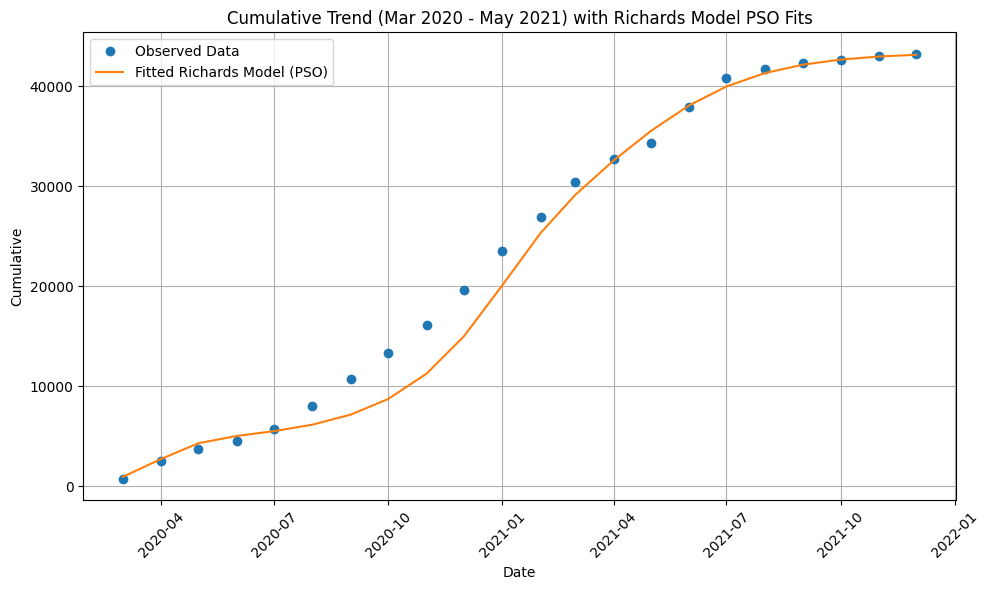

Root Mean Squared Error (RMSE): 2156.2938730461033
Mean Squared Error (MSE): 4649603.266936165


In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3):
    return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1) + A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2) + A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2011
start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2021-12-31')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb = [0, 0, min(t_data), 0.01, 0, 0, min(t_data), 0.01, 0, 0, min(t_data), 0.01]  # Lower bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3
ub = [max(y_observed), 10, max(t_data), 5, max(y_observed), 10, max(t_data), 5, max(y_observed), 10, max(t_data), 5]  # Upper bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed), swarmsize = 300)

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2a_opt, k2a_opt, t02a_opt, nu2a_opt, A3_opt, k3_opt, t03_opt, nu3_opt = params_opt
print(f"Optimal parameters: A1={A_opt}, k1={k_opt}, t01={t0_opt}, nu1={nu_opt}, A2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}, A3={A3_opt}, k3={k3_opt}, t03={t03_opt}, nu3={nu3_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A_opt, k_opt, t0_opt, nu_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Mar 2020 - May 2021) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse3 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse3}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse3 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse3}")

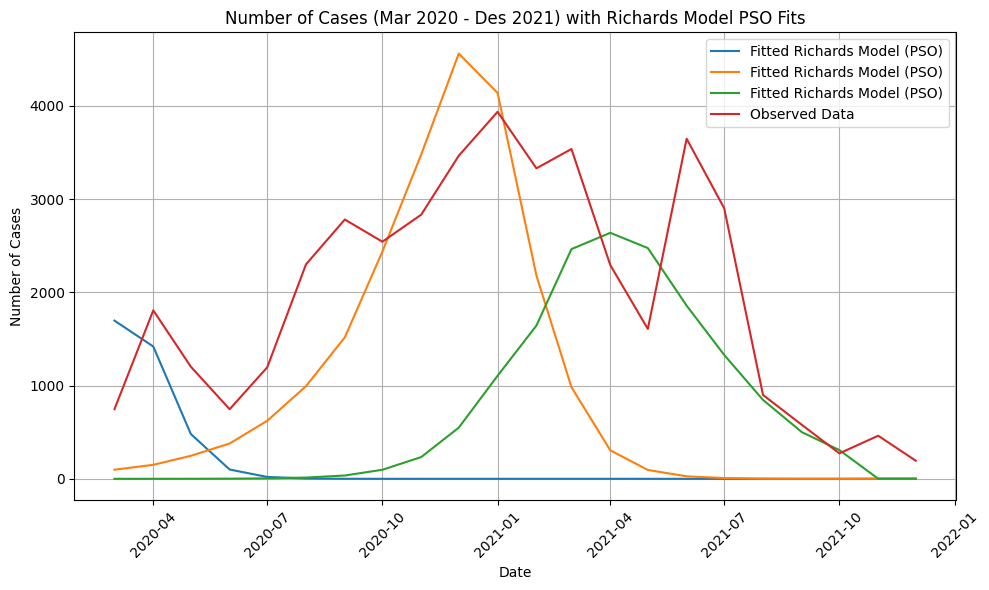

In [ ]:
def richards(t, A1, k1, t01, nu1):
    return A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)

y_predicted1 = richards(t_data, A_opt, k_opt, t0_opt, nu_opt)
y_predicted2 = richards(t_data, A2_opt, k2_opt, t02_opt, nu2_opt)
y_predicted3 = richards(t_data, A3_opt, k3_opt, t03_opt, nu3_opt)
ysubs1 =np.ones(len(y_predicted1))
ysubs2 =np.ones(len(y_predicted2))
ysubs3 =np.ones(len(y_predicted3))
for i in range (1,len(y_predicted1)-1) :
  ysubs1[i-1] = y_predicted1[i] - y_predicted1[i-1]
  ysubs2[i-1] = y_predicted2[i] - y_predicted2[i-1]
  ysubs3[i-1] = y_predicted3[i] - y_predicted3[i-1]

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], ysubs1, '-', label='Fitted Richards Model (PSO)')
plt.plot(filtered_df['Date'], ysubs2, '-', label='Fitted Richards Model (PSO)')
plt.plot(filtered_df['Date'], ysubs3, '-', label='Fitted Richards Model (PSO)')
plt.plot(filtered_df['Date'], filtered_df['total'], label='Observed Data')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Number of Cases (Mar 2020 - Des 2021) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4):
    richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
    richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
    richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
    richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
    return richards1 + richards2 + richards3 + richards4
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to October 2012
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2012-10-31')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb1 = [0, 0, min(t_data), 0.01]
lb = lb1 + lb1 + lb1 + lb1  # Lower bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4
ub1 = [max(y_observed), 10, max(t_data), 5]
ub = ub1 + ub1 + ub1 + ub1 # Upper bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed))

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt, \
A4_opt, k4_opt, t04_opt, nu4_opt = params_opt
print(f"Optimal parameters: A1={A1_opt}, k1={k1_opt}, t01={t01_opt}, nu1={nu1_opt}, \nA2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}, \
\nA3={A3_opt}, k3={k3_opt}, t03={t03_opt}, nu3={nu3_opt}, \nA4={A4_opt}, k4={k4_opt}, t04={t04_opt}, nu4={nu4_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt,
                                 A4_opt, k4_opt, t04_opt, nu4_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
#plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Data')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Jan 2008 - Oct 2012) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse4 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse4}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse4 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse4}")

ValueError: min() arg is an empty sequence

<ipython-input-179-7564b303e1eb>:5: RuntimeWarning: overflow encountered in exp
  richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
<ipython-input-179-7564b303e1eb>:6: RuntimeWarning: overflow encountered in exp
  richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
<ipython-input-179-7564b303e1eb>:7: RuntimeWarning: overflow encountered in exp
  richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
<ipython-input-179-7564b303e1eb>:3: RuntimeWarning: overflow encountered in exp
  richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
<ipython-input-179-7564b303e1eb>:4: RuntimeWarning: overflow encountered in exp
  richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)


Stopping search: maximum iterations reached --> 100
Optimal parameters: A1=2722.8282164799834, k1=0.002628886150865056, t01=1338.6939820352347, nu1=3.7426852938169515, 
A2=18714.465355995297, k2=5.841331221266195, t02=820.8428612226885, nu2=0.5451964590217125, 
A3=48390.41146172812, k3=0.006508060880730784, t03=1601.9000306748285, nu3=3.299998218366087, 
A4=28546.400954279936, k4=4.783452239390664, t04=425.589680893861, nu4=4.435714230056535, 
A5=17587.248127545085, k5=4.391573974853257, t05=81.10541913846944, nu5=3.6999389633867086


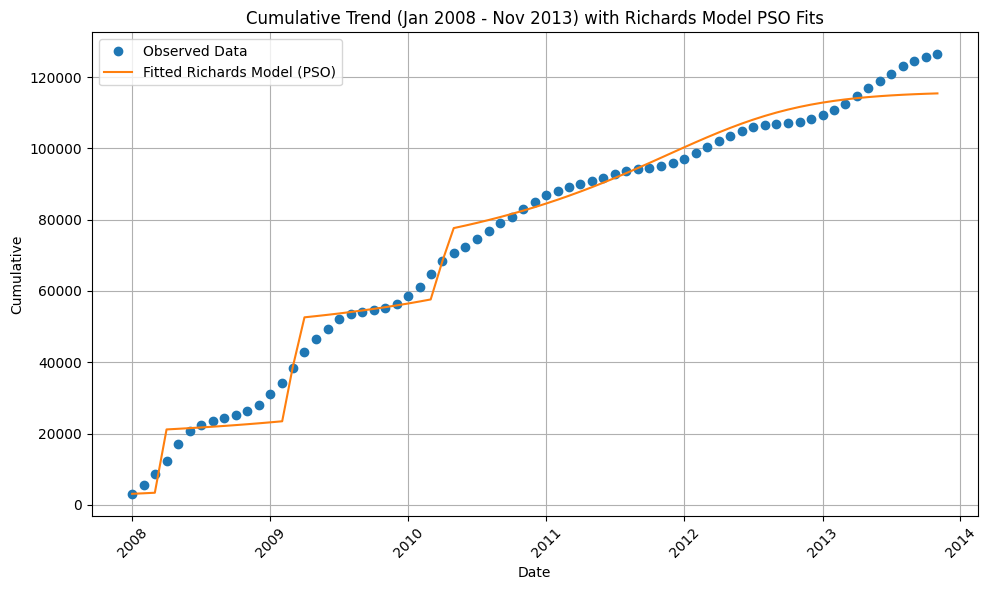

Root Mean Squared Error (RMSE): 4328.677376857395
Mean Squared Error (MSE): 18737447.832917016


In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5):
    richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
    richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
    richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
    richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
    richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
    return richards1 + richards2 + richards3 + richards4 + richards5
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2013
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2013-11-30')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb1 = [0, 0, min(t_data), 0.01]
lb = lb1 + lb1 + lb1 + lb1 + lb1  # Lower bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4
ub1 = [max(y_observed), 10, max(t_data), 5]
ub = ub1 + ub1 + ub1 + ub1 + ub1# Upper bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed))

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt, \
A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt = params_opt
print(f"Optimal parameters: A1={A1_opt}, k1={k1_opt}, t01={t01_opt}, nu1={nu1_opt}, \nA2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}, \
\nA3={A3_opt}, k3={k3_opt}, t03={t03_opt}, nu3={nu3_opt}, \nA4={A4_opt}, k4={k4_opt}, t04={t04_opt}, nu4={nu4_opt}, \
\nA5={A5_opt}, k5={k5_opt}, t05={t05_opt}, nu5={nu5_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt,
                                 A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Jan 2008 - Nov 2013) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse5 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse5}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse5 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse5}")

<ipython-input-187-418cd589634c>:4: RuntimeWarning: overflow encountered in exp
  richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
<ipython-input-187-418cd589634c>:5: RuntimeWarning: overflow encountered in exp
  richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
<ipython-input-187-418cd589634c>:6: RuntimeWarning: overflow encountered in exp
  richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
<ipython-input-187-418cd589634c>:7: RuntimeWarning: overflow encountered in exp
  richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
<ipython-input-187-418cd589634c>:8: RuntimeWarning: overflow encountered in exp
  richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
<ipython-input-187-418cd589634c>:9: RuntimeWarning: overflow encountered in exp
  richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)


Stopping search: maximum iterations reached --> 100
Optimal parameters: A1=25467.81177864176, k1=3.3718938805639795, t01=821.7766219723492, nu1=3.5436404566317905, 
A2=39129.628329258616, k2=0.021061095245053375, t02=462.832082449467, nu2=2.518858853938343, 
A3=14805.628792426682, k3=7.915476433710004, t03=2280.602968867271, nu3=4.910447555411094, 
A4=23578.706473440707, k4=7.943107640546708, t04=1917.386856545262, nu4=4.328701152727338, 
A5=22125.487096215333, k5=0.018196907051496153, t05=1420.386365841953, nu5=3.280389634052283, 
A6=16521.48280696601, k6=8.678142089494013, t06=73.50450658377913, nu6=2.98951927269102


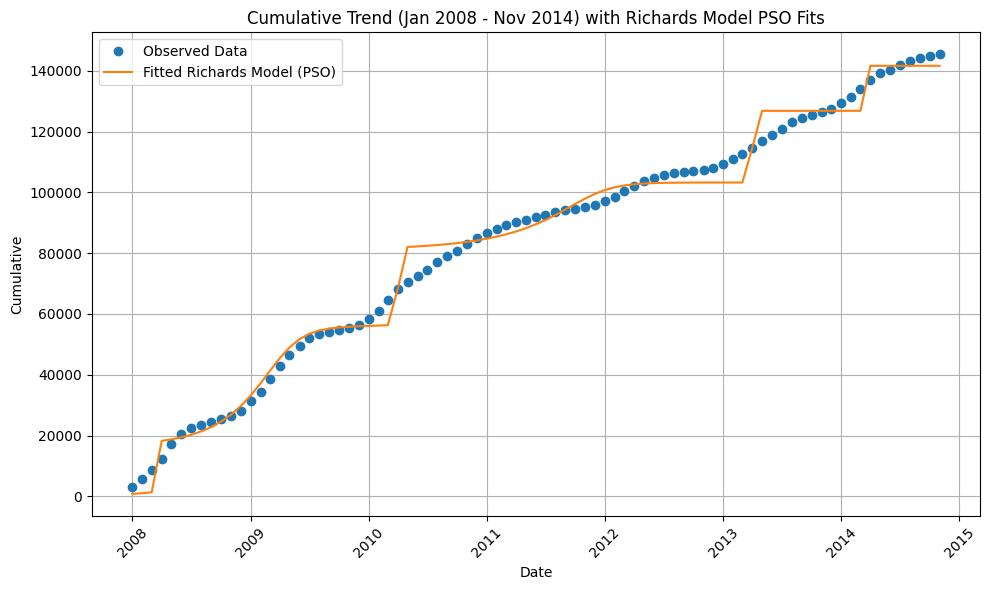

Root Mean Squared Error (RMSE): 4043.263286924477
Mean Squared Error (MSE): 16347978.007391326


In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                   A6, k6, t06, nu6):
    richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
    richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
    richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
    richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
    richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
    richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)
    return richards1 + richards2 + richards3 + richards4 + richards5 + richards6
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
    A6, k6, t06, nu6 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                                 A6, k6, t06, nu6)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2013
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2014-11-30')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb1 = [0, 0, min(t_data), 0.01]
lb = lb1 + lb1 + lb1 + lb1 + lb1 + lb1  # Lower bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4
ub1 = [max(y_observed), 10, max(t_data), 5]
ub = ub1 + ub1 + ub1 + ub1 + ub1 + ub1 # Upper bounds for A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed))

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt, \
A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt = params_opt
print(f"Optimal parameters: A1={A1_opt}, k1={k1_opt}, t01={t01_opt}, nu1={nu1_opt}, \nA2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}, \
\nA3={A3_opt}, k3={k3_opt}, t03={t03_opt}, nu3={nu3_opt}, \nA4={A4_opt}, k4={k4_opt}, t04={t04_opt}, nu4={nu4_opt}, \
\nA5={A5_opt}, k5={k5_opt}, t05={t05_opt}, nu5={nu5_opt}, \nA6={A6_opt}, k6={k6_opt}, t06={t06_opt}, nu6={nu6_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt,
                                 A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Jan 2008 - Nov 2014) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse6 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse6}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse6 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse6}")

<ipython-input-230-24bd9d518ee2>:4: RuntimeWarning: overflow encountered in exp
  richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
<ipython-input-230-24bd9d518ee2>:5: RuntimeWarning: overflow encountered in exp
  richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
<ipython-input-230-24bd9d518ee2>:6: RuntimeWarning: overflow encountered in exp
  richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
<ipython-input-230-24bd9d518ee2>:7: RuntimeWarning: overflow encountered in exp
  richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
<ipython-input-230-24bd9d518ee2>:8: RuntimeWarning: overflow encountered in exp
  richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
<ipython-input-230-24bd9d518ee2>:9: RuntimeWarning: overflow encountered in exp
  richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)
<ipython-input-230-24bd9d518ee2>:10: RuntimeWarning: overflow encountered in exp
  richards7 = A7 * (1 + np.exp(-k7 * (t - t07))) ** (-1 / nu7

Stopping search: maximum iterations reached --> 100
Optimal parameters: A1=16873.498457697537, k1=2.540716906165341, t01=2840.8154120226477, nu1=4.9991293817396185, 
A2=30205.4334488371, k2=7.382183917802943, t02=107.69943824318487, nu2=4.541432860768516, 
A3=529.076881340915, k3=2.0243627809130107, t03=2860.764610673512, nu3=4.4167964145568535, 
A4=19015.94694547812, k4=9.765692204071485, t04=1492.2001237901072, nu4=2.3523405049937556, 
A5=23671.387170691967, k5=3.1688657210677835, t05=441.84730773394784, nu5=4.443828476906069, 
A6=40236.66198145176, k6=0.0075092723394739255, t06=2027.1337531021743, nu6=0.41018868615039294, 
A7=36442.77577869213, k7=5.67763955431458, t07=882.4443578668607, nu7=3.850559663533827


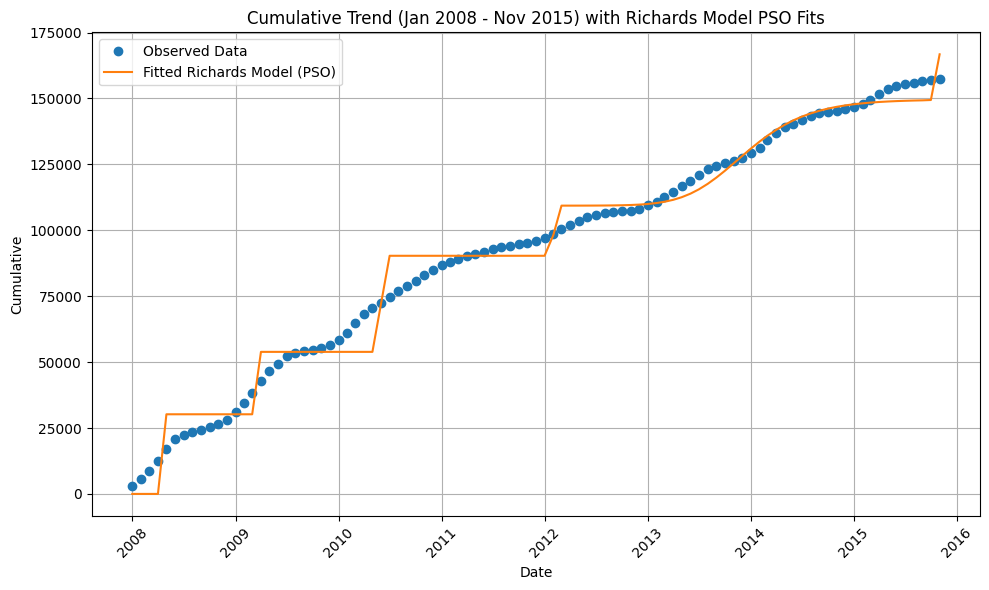

Root Mean Squared Error (RMSE): 5925.9594151422025
Mean Squared Error (MSE): 35116994.98991251


In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                   A6, k6, t06, nu6, A7, k7, t07, nu7):
    richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
    richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
    richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
    richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
    richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
    richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)
    richards7 = A7 * (1 + np.exp(-k7 * (t - t07))) ** (-1 / nu7)
    return richards1 + richards2 + richards3 + richards4 + richards5 + richards6 + richards7
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
    A6, k6, t06, nu6, A7, k7, t07, nu7 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                                 A6, k6, t06, nu6, A7, k7, t07, nu7)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2013
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2015-11-30')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb1 = [0, 0, min(t_data), 0.01]
lb = lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 # Lower bounds
ub1 = [max(y_observed), 10, max(t_data), 5]
ub = ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 # Upper bounds

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed))

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt, \
A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt, \
A7_opt, k7_opt, t07_opt, nu7_opt = params_opt
print(f"Optimal parameters: A1={A1_opt}, k1={k1_opt}, t01={t01_opt}, nu1={nu1_opt}, \nA2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}, \
\nA3={A3_opt}, k3={k3_opt}, t03={t03_opt}, nu3={nu3_opt}, \nA4={A4_opt}, k4={k4_opt}, t04={t04_opt}, nu4={nu4_opt}, \
\nA5={A5_opt}, k5={k5_opt}, t05={t05_opt}, nu5={nu5_opt}, \nA6={A6_opt}, k6={k6_opt}, t06={t06_opt}, nu6={nu6_opt}, \
\nA7={A7_opt}, k7={k7_opt}, t07={t07_opt}, nu7={nu7_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt,
                                 A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt,
                                 A7_opt, k7_opt, t07_opt, nu7_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Jan 2008 - Nov 2015) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse7 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse7}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse7 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse7}")

<ipython-input-282-ca34dd79e55a>:4: RuntimeWarning: overflow encountered in exp
  richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
<ipython-input-282-ca34dd79e55a>:5: RuntimeWarning: overflow encountered in exp
  richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
<ipython-input-282-ca34dd79e55a>:6: RuntimeWarning: overflow encountered in exp
  richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
<ipython-input-282-ca34dd79e55a>:7: RuntimeWarning: overflow encountered in exp
  richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
<ipython-input-282-ca34dd79e55a>:8: RuntimeWarning: overflow encountered in exp
  richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
<ipython-input-282-ca34dd79e55a>:9: RuntimeWarning: overflow encountered in exp
  richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)
<ipython-input-282-ca34dd79e55a>:10: RuntimeWarning: overflow encountered in exp
  richards7 = A7 * (1 + np.exp(-k7 * (t - t07))) ** (-1 / nu7

Stopping search: maximum iterations reached --> 100
Optimal parameters: A1=35779.64728349322, k1=2.7819197497260477, t01=3013.1860510160773, nu1=1.561598918036134, 
A2=22326.697565409457, k2=3.625119843179875, t02=2497.0154806810283, nu2=4.491484064450646, 
A3=63076.37176968332, k3=0.005180641919069186, t03=1176.5525403040708, nu3=1.6599539714857736, 
A4=23857.431341941046, k4=6.978802900503793, t04=2184.5632500732736, nu4=3.290256047947749, 
A5=28714.39653930194, k5=2.006001884219342, t05=456.5564951428554, nu5=2.3698762767428208, 
A6=4542.740732331712, k6=7.677708154758228, t06=3162.7739716469564, nu6=2.7031716038259463, 
A7=19901.43529187702, k7=9.77732066151466, t07=46.502169810299264, nu7=2.514557074723762, 
A8=99.51235908553181, k8=7.977550925202129, t08=271.744029069509, nu8=0.7257038562810825


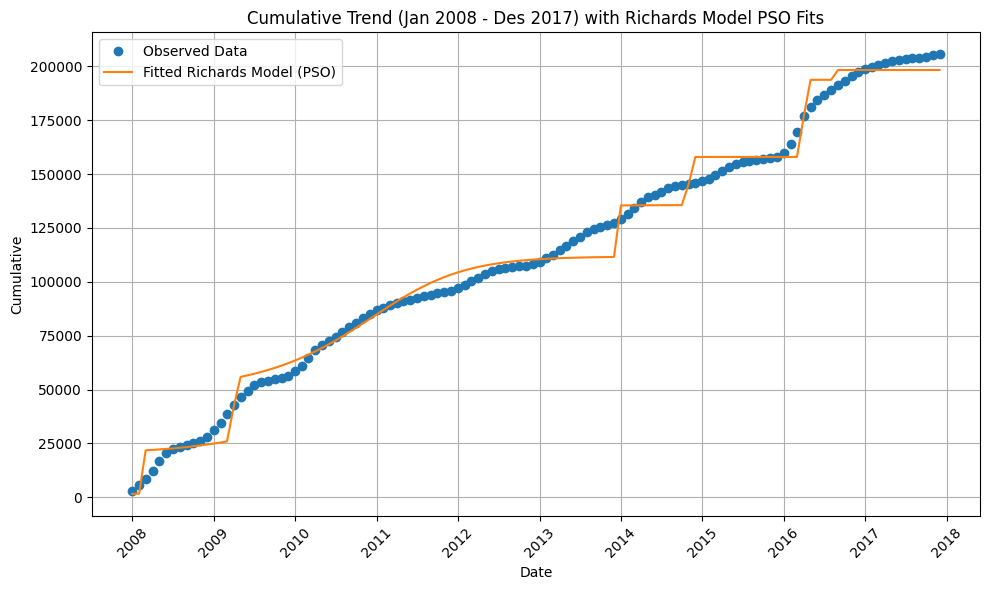

Root Mean Squared Error (RMSE): 6037.963733549036
Mean Squared Error (MSE): 36457006.047653414


In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                   A6, k6, t06, nu6, A7, k7, t07, nu7, A8, k8, t08, nu8):
    richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
    richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
    richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
    richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
    richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
    richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)
    richards7 = A7 * (1 + np.exp(-k7 * (t - t07))) ** (-1 / nu7)
    richards8 = A8 * (1 + np.exp(-k8 * (t - t08))) ** (-1 / nu8)
    return richards1 + richards2 + richards3 + richards4 + richards5 + richards6 + richards7 + richards8
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
    A6, k6, t06, nu6, A7, k7, t07, nu7, A8, k8, t08, nu8 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                                 A6, k6, t06, nu6, A7, k7, t07, nu7, A8, k8, t08, nu8)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2013
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2017-12-31')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb1 = [0, 0, min(t_data), 0.01]
lb = lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 # Lower bounds
ub1 = [max(y_observed), 10, max(t_data), 5]
ub = ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 # Upper bounds

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed))

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt, \
A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt, \
A7_opt, k7_opt, t07_opt, nu7_opt, A8_opt, k8_opt, t08_opt, nu8_opt = params_opt
print(f"Optimal parameters: A1={A1_opt}, k1={k1_opt}, t01={t01_opt}, nu1={nu1_opt}, \nA2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}, \
\nA3={A3_opt}, k3={k3_opt}, t03={t03_opt}, nu3={nu3_opt}, \nA4={A4_opt}, k4={k4_opt}, t04={t04_opt}, nu4={nu4_opt}, \
\nA5={A5_opt}, k5={k5_opt}, t05={t05_opt}, nu5={nu5_opt}, \nA6={A6_opt}, k6={k6_opt}, t06={t06_opt}, nu6={nu6_opt}, \
\nA7={A7_opt}, k7={k7_opt}, t07={t07_opt}, nu7={nu7_opt}, \nA8={A8_opt}, k8={k8_opt}, t08={t08_opt}, nu8={nu8_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt,
                                 A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt,
                                 A7_opt, k7_opt, t07_opt, nu7_opt, A8_opt, k8_opt, t08_opt, nu8_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Jan 2008 - Des 2017) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse8 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse8}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse8 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse8}")

<ipython-input-445-c9d4ef044aa7>:4: RuntimeWarning: overflow encountered in exp
  richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
<ipython-input-445-c9d4ef044aa7>:5: RuntimeWarning: overflow encountered in exp
  richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
<ipython-input-445-c9d4ef044aa7>:6: RuntimeWarning: overflow encountered in exp
  richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
<ipython-input-445-c9d4ef044aa7>:7: RuntimeWarning: overflow encountered in exp
  richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
<ipython-input-445-c9d4ef044aa7>:8: RuntimeWarning: overflow encountered in exp
  richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
<ipython-input-445-c9d4ef044aa7>:9: RuntimeWarning: overflow encountered in exp
  richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)
<ipython-input-445-c9d4ef044aa7>:10: RuntimeWarning: overflow encountered in exp
  richards7 = A7 * (1 + np.exp(-k7 * (t - t07))) ** (-1 / nu7

Stopping search: maximum iterations reached --> 100
Optimal parameters: A1=0.0, k1=5.238761925612203, t01=3474.5202332144995, nu1=2.285030173475151, 
A2=68652.70764191663, k2=0.0, t02=1839.2527887283836, nu2=0.02080253774265826, 
A3=32899.802818387936, k3=8.50918425339052, t03=851.3380645066374, nu3=4.426848016493002, 
A4=134030.92855901405, k4=0.004577341939136262, t04=3171.8224260182415, nu4=5.0, 
A5=11.205414733148936, k5=8.593874035207229, t05=2215.036968086751, nu5=4.998885418453628, 
A6=0.0, k6=3.376927674934345, t06=909.2555366941918, nu6=0.01, 
A7=24194.090795220203, k7=4.596618822383546, t07=425.60350877434314, nu7=4.999989195593386, 
A8=164775.26518073963, k8=9.997297427869238, t08=3622.0, nu8=0.2717452538746621, 
A9=13764.599616835318, k9=8.53792482118036, t09=0.0, nu9=0.01


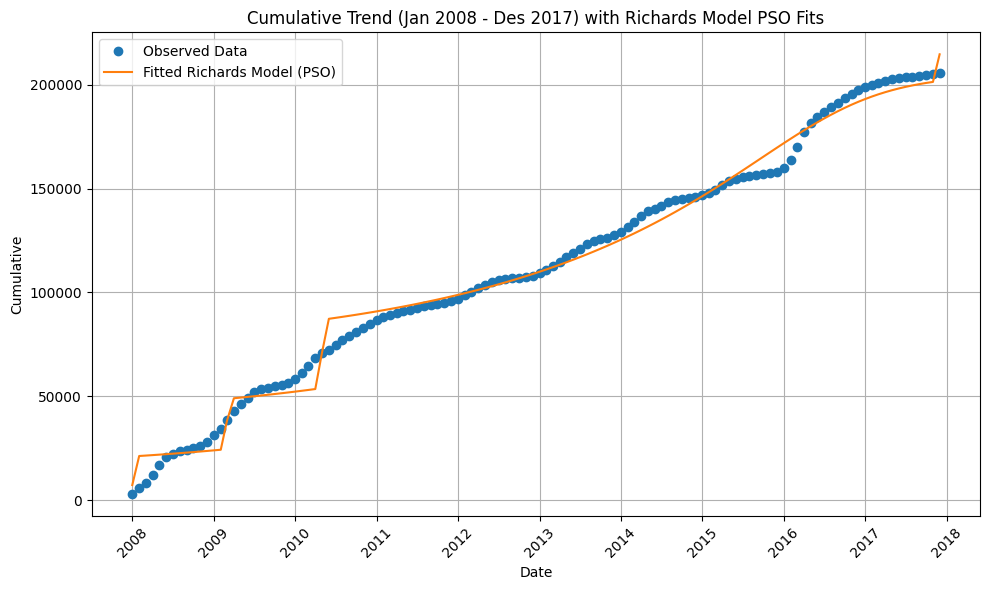

Root Mean Squared Error (RMSE): 5634.545868603174
Mean Squared Error (MSE): 31748107.1453931


In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                   A6, k6, t06, nu6, A7, k7, t07, nu7, A8, k8, t08, nu8, A9, k9, t09, nu9):
    richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
    richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
    richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
    richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
    richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
    richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)
    richards7 = A7 * (1 + np.exp(-k7 * (t - t07))) ** (-1 / nu7)
    richards8 = A8 * (1 + np.exp(-k8 * (t - t08))) ** (-1 / nu8)
    richards9 = A9 * (1 + np.exp(-k9 * (t - t09))) ** (-1 / nu9)
    return richards1 + richards2 + richards3 + richards4 + richards5 + richards6 + richards7 + richards8 + richards9
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
    A6, k6, t06, nu6, A7, k7, t07, nu7, A8, k8, t08, nu8, A9, k9, t09, nu9 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                                 A6, k6, t06, nu6, A7, k7, t07, nu7, A8, k8, t08, nu8, A9, k9, t09, nu9)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2013
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2017-12-31')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb1 = [0, 0, min(t_data), 0.01]
lb = lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 # Lower bounds
ub1 = [max(y_observed), 10, max(t_data), 5]
ub = ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 # Upper bounds

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed))

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt, \
A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt, \
A7_opt, k7_opt, t07_opt, nu7_opt, A8_opt, k8_opt, t08_opt, nu8_opt, A9_opt, k9_opt, t09_opt, nu9_opt = params_opt
print(f"Optimal parameters: A1={A1_opt}, k1={k1_opt}, t01={t01_opt}, nu1={nu1_opt}, \nA2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}, \
\nA3={A3_opt}, k3={k3_opt}, t03={t03_opt}, nu3={nu3_opt}, \nA4={A4_opt}, k4={k4_opt}, t04={t04_opt}, nu4={nu4_opt}, \
\nA5={A5_opt}, k5={k5_opt}, t05={t05_opt}, nu5={nu5_opt}, \nA6={A6_opt}, k6={k6_opt}, t06={t06_opt}, nu6={nu6_opt}, \
\nA7={A7_opt}, k7={k7_opt}, t07={t07_opt}, nu7={nu7_opt}, \nA8={A8_opt}, k8={k8_opt}, t08={t08_opt}, nu8={nu8_opt}, \
\nA9={A9_opt}, k9={k9_opt}, t09={t09_opt}, nu9={nu9_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt,
                                 A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt,
                                 A7_opt, k7_opt, t07_opt, nu7_opt, A8_opt, k8_opt, t08_opt, nu8_opt, A9_opt, k9_opt, t09_opt, nu9_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Jan 2008 - Des 2017) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse9 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse9}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse9 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse9}")

<ipython-input-409-7049272eb83c>:4: RuntimeWarning: overflow encountered in exp
  richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
<ipython-input-409-7049272eb83c>:6: RuntimeWarning: overflow encountered in exp
  richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
<ipython-input-409-7049272eb83c>:7: RuntimeWarning: overflow encountered in exp
  richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
<ipython-input-409-7049272eb83c>:8: RuntimeWarning: overflow encountered in exp
  richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
<ipython-input-409-7049272eb83c>:9: RuntimeWarning: overflow encountered in exp
  richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)
<ipython-input-409-7049272eb83c>:10: RuntimeWarning: overflow encountered in exp
  richards7 = A7 * (1 + np.exp(-k7 * (t - t07))) ** (-1 / nu7)
<ipython-input-409-7049272eb83c>:11: RuntimeWarning: overflow encountered in exp
  richards8 = A8 * (1 + np.exp(-k8 * (t - t08))) ** (-1 / nu

Stopping search: maximum iterations reached --> 100
Optimal parameters: A1=7010.186605700556, k1=1.1024116405066808, t01=3117.2657880158886, nu1=3.1634972956414207, 
A2=34359.41000754468, k2=0.0011889931472697322, t02=2325.7907990404856, nu2=4.238023693490337, 
A3=23505.790386115452, k3=5.502173459794935, t03=1670.2108312404605, nu3=0.12284853090911578, 
A4=31426.159765055843, k4=5.6964437223087145, t04=3043.0182082176557, nu4=1.5243281912563524, 
A5=11166.387195955283, k5=9.764432008674481, t05=3608.110654366499, nu5=4.38100543766363, 
A6=21110.3770574775, k6=5.00683997337129, t06=2521.416591767838, nu6=2.6875128854870796, 
A7=11774.247754753593, k7=0.548449027711565, t07=2637.177179360064, nu7=4.733483339463323, 
A8=57540.11519726552, k8=0.015328302441030218, t08=956.566620557232, nu8=4.995543086942329, 
A9=8106.380479373168, k9=7.9660135182727, t09=375.40917064484233, nu9=1.2566948168611525, 
A10=8616.060525466775, k10=2.6113731140378524, t010=1925.7675857591291, nu10=1.928733700690

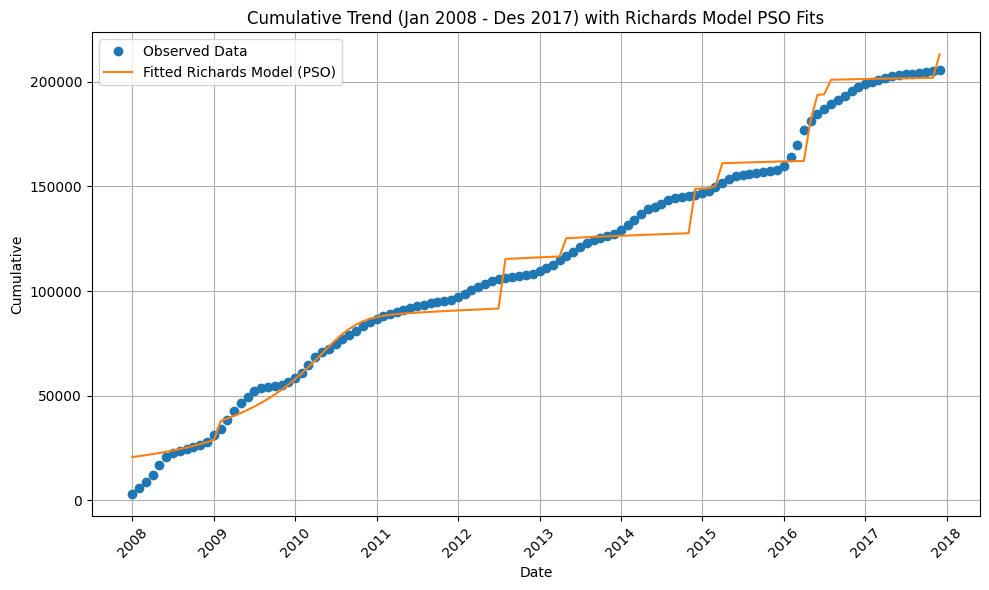

Root Mean Squared Error (RMSE): 6957.684832118641
Mean Squared Error (MSE): 48409378.22309379


In [ ]:
# Define Richards Model
def richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                   A6, k6, t06, nu6, A7, k7, t07, nu7, A8, k8, t08, nu8, A9, k9, t09, nu9, A10, k10, t010, nu10):
    richards1 = A1 * (1 + np.exp(-k1 * (t - t01))) ** (-1 / nu1)
    richards2 = A2 * (1 + np.exp(-k2 * (t - t02))) ** (-1 / nu2)
    richards3 = A3 * (1 + np.exp(-k3 * (t - t03))) ** (-1 / nu3)
    richards4 = A4 * (1 + np.exp(-k4 * (t - t04))) ** (-1 / nu4)
    richards5 = A5 * (1 + np.exp(-k5 * (t - t05))) ** (-1 / nu5)
    richards6 = A6 * (1 + np.exp(-k6 * (t - t06))) ** (-1 / nu6)
    richards7 = A7 * (1 + np.exp(-k7 * (t - t07))) ** (-1 / nu7)
    richards8 = A8 * (1 + np.exp(-k8 * (t - t08))) ** (-1 / nu8)
    richards9 = A9 * (1 + np.exp(-k9 * (t - t09))) ** (-1 / nu9)
    richards10 = A10 * (1 + np.exp(-k10 * (t - t010))) ** (-1 / nu10)
    return richards1 + richards2 + richards3 + richards4 + richards5 + richards6 + richards7 + richards8 + richards9 + richards10
# A is the upper asymptote (carrying capacity),
# k is the growth rate,
# t0 is the inflection point (the time at which the growth rate is maximum),
# nu(or sometimes is a shape parameter that allows the model to accommodate different growth shapes (flexibility).

# Define the objective function (sum of squared errors)
def objective_function(params, t, y_observed):
    A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
    A6, k6, t06, nu6, A7, k7, t07, nu7, A8, k8, t08, nu8, A9, k9, t09, nu9, A10, k10, t010, nu10 = params
    y_predicted = richards_model(t, A1, k1, t01, nu1, A2, k2, t02, nu2, A3, k3, t03, nu3, A4, k4, t04, nu4, A5, k5, t05, nu5,\
                                 A6, k6, t06, nu6, A7, k7, t07, nu7, A8, k8, t08, nu8, A9, k9, t09, nu9, A10, k10, t010, nu10)
    return np.sum((y_observed - y_predicted) ** 2)

# ... (Your existing code for loading data and filtering) ...
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2013
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2017-12-31')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Time data and observed data (y_observed)
t_data = np.array((filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values)  # Fill in your time points
y_observed = np.array(filtered_df['cumulative'].values)  # Fill in your observed data points

# Define parameter bounds (to avoid unrealistic values)
# Updated bounds for 8 parameters
lb1 = [0, 0, min(t_data), 0.01]
lb = lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 + lb1 # Lower bounds
ub1 = [max(y_observed), 10, max(t_data), 5]
ub = ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 + ub1 # Upper bounds

# Run PSO to optimize parameters
params_opt, _ = pso(objective_function, lb, ub, args=(t_data, y_observed))

# Output optimal parameters
A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt, \
A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt, \
A7_opt, k7_opt, t07_opt, nu7_opt, A8_opt, k8_opt, t08_opt, nu8_opt, A9_opt, k9_opt, t09_opt, nu9_opt, \
A10_opt, k10_opt, t010_opt, nu10_opt = params_opt
print(f"Optimal parameters: A1={A1_opt}, k1={k1_opt}, t01={t01_opt}, nu1={nu1_opt}, \nA2={A2_opt}, k2={k2_opt}, t02={t02_opt}, nu2={nu2_opt}, \
\nA3={A3_opt}, k3={k3_opt}, t03={t03_opt}, nu3={nu3_opt}, \nA4={A4_opt}, k4={k4_opt}, t04={t04_opt}, nu4={nu4_opt}, \
\nA5={A5_opt}, k5={k5_opt}, t05={t05_opt}, nu5={nu5_opt}, \nA6={A6_opt}, k6={k6_opt}, t06={t06_opt}, nu6={nu6_opt}, \
\nA7={A7_opt}, k7={k7_opt}, t07={t07_opt}, nu7={nu7_opt}, \nA8={A8_opt}, k8={k8_opt}, t08={t08_opt}, nu8={nu8_opt}, \
\nA9={A9_opt}, k9={k9_opt}, t09={t09_opt}, nu9={nu9_opt}, \nA10={A10_opt}, k10={k10_opt}, t010={t010_opt}, nu10={nu10_opt}")

# Generate predicted values using the optimal parameters
y_predicted_pso = richards_model(t_data, A1_opt, k1_opt, t01_opt, nu1_opt, A2_opt, k2_opt, t02_opt, nu2_opt, A3_opt, k3_opt, t03_opt, nu3_opt,
                                 A4_opt, k4_opt, t04_opt, nu4_opt, A5_opt, k5_opt, t05_opt, nu5_opt, A6_opt, k6_opt, t06_opt, nu6_opt,
                                 A7_opt, k7_opt, t07_opt, nu7_opt, A8_opt, k8_opt, t08_opt, nu8_opt, A9_opt, k9_opt, t09_opt, nu9_opt,
                                 A10_opt, k10_opt, t010_opt, nu10_opt)

# Plot the data, the fitted curve from curve_fit, and the PSO fitted curve
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Date'], y_observed, 'o', label='Observed Data')
plt.plot(filtered_df['Date'], y_predicted_pso, '-', label='Fitted Richards Model (PSO)')

plt.xlabel('Date')
plt.ylabel('Cumulative')
plt.title('Cumulative Trend (Jan 2008 - Des 2017) with Richards Model PSO Fits')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for each date
mse_values = (y_observed - y_predicted_pso)**2

# Calculate RMSE
rmse10 = np.sqrt(np.mean(mse_values))
print(f"Root Mean Squared Error (RMSE): {rmse10}")

# Calculate MSE (already calculated above, but printing again for clarity)
mse10 = np.mean(mse_values)
print(f"Mean Squared Error (MSE): {mse10}")

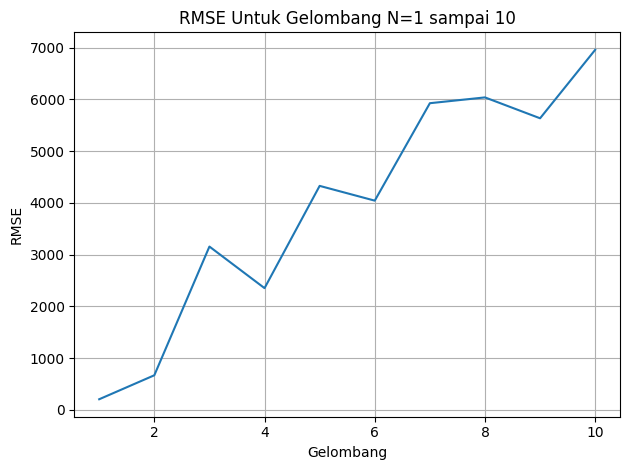

In [ ]:
t = np.array([1,2,3,4,5,6,7,8,9,10])
err = np.array([rmse1, rmse2, rmse3, rmse4, rmse5, rmse6, rmse7, rmse8, rmse9, rmse10])
plt.plot(t,err)
plt.xlabel('Gelombang')
plt.ylabel('RMSE')
plt.title('RMSE Untuk Gelombang N=1 sampai 10')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-6-fb3152c55d9c>:34: RuntimeWarning: overflow encountered in exp
  return a + (c - a) * (1 + (b * np.exp(-d * t))) ** (-1)


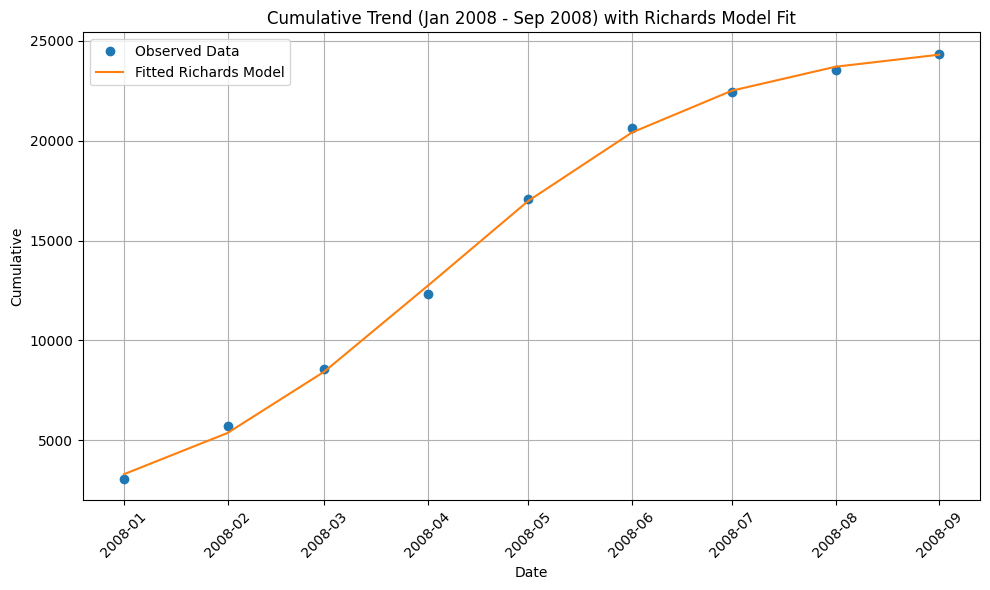

Fitted Parameters:
a (initial population): 1130.8181595454166
b (growth rate): 9.874341484858615
c (carrying capacity): 24845.13173817205
d (growth shape parameter): 0.024714874001879366


In [ ]:
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to September 2008
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2008-09-30')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Extract x (time) and y (cumulative) data
x_data = (filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values
y_data = filtered_df['cumulative'].values

# Define the Richards modification of the logistic model
def richards_model(t, a, b, c, d):
  """
  Richards model for population growth.

  Args:
    t: Time (independent variable).
    a: Initial population size.
    b: Growth rate.
    c: Carrying capacity.
    d: Growth shape parameter.

  Returns:
    The predicted population size at time t.
  """
  return a + (c - a) * (1 + (b * np.exp(-d * t))) ** (-1)

# Fit the model to the data
try:
  popt, _ = curve_fit(richards_model, x_data, y_data,
                      p0=[y_data[0], 1, np.max(y_data), 0.1],
                      maxfev=10000)  # Initial guess for parameters

  # Extract the fitted parameters
  a, b, c, d = popt

  # Generate predicted values for plotting
  x_fit = np.linspace(x_data.min(), x_data.max(), 100)
  y_fit = richards_model(x_fit, a, b, c, d)

  # Plot the data and the fitted curve
  plt.figure(figsize=(10, 6))
  plt.plot(filtered_df['Date'], y_data, 'o', label='Observed Data')
  plt.plot(filtered_df['Date'], richards_model(x_data, a, b, c, d), '-', label='Fitted Richards Model')

  plt.xlabel('Date')
  plt.ylabel('Cumulative')
  plt.title('Cumulative Trend (Jan 2008 - Sep 2008) with Richards Model Fit')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  print("Fitted Parameters:")
  print("a (initial population):", a)
  print("b (growth rate):", b)
  print("c (carrying capacity):", c)
  print("d (growth shape parameter):", d)

except RuntimeError:
  print("Optimal parameters not found. Curve fitting may have failed.")

<ipython-input-10-1d2243643028>:36: RuntimeWarning: overflow encountered in exp
  return a1 + (c1 - a1) * (1 + (b1 * np.exp(-d1 * t))) ** (-1) + a2 + (c2 - a2) * (1 + (b2 * np.exp(-d2 * t))) ** (-1)


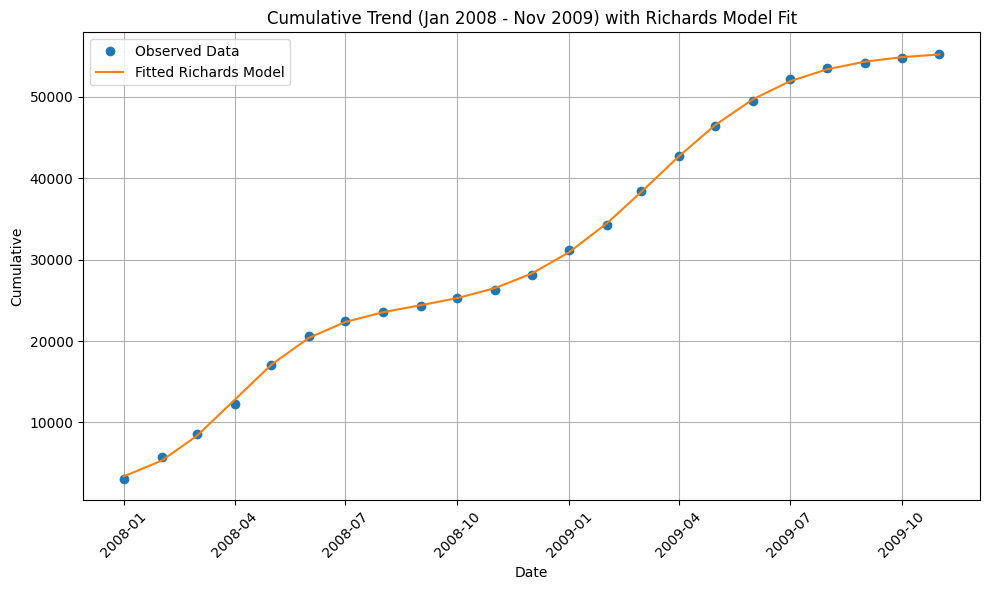

Fitted Parameters:
a1 (initial population): -4347055.858523812
b1 (growth rate): 2416.7132692053983
c1 (carrying capacity): -4315117.801747674
d1 (growth shape parameter): 0.01791245620222126
a2 (initial population): 4348695.042539637
b2 (growth rate): 11.695372066087984
c2 (carrying capacity): 4370796.251513534
d2 (growth shape parameter): 0.02706835370810802


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Replace 'your_file.xlsx' with the actual path to your Excel file
df = pd.read_excel('DBD.xlsx')

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2009
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2009-11-30')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Extract x (time) and y (cumulative) data
x_data = (filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values
y_data = filtered_df['cumulative'].values

# Define the Richards modification of the logistic model
def richards_model(t, a1, b1, c1, d1, a2, b2, c2, d2):
  """
  Richards model for population growth.

  Args:
    t: Time (independent variable).
    a: Initial population size.
    b: Growth rate.
    c: Carrying capacity.
    d: Growth shape parameter.

  Returns:
    The predicted population size at time t.
  """
  return a1 + (c1 - a1) * (1 + (b1 * np.exp(-d1 * t))) ** (-1) + a2 + (c2 - a2) * (1 + (b2 * np.exp(-d2 * t))) ** (-1)

# Fit the model to the data
try:
  popt, _ = curve_fit(richards_model, x_data, y_data,
                      p0=[y_data[0], 1, np.max(y_data), 0.1, y_data[0], 1, np.max(y_data), 0.1],
                      maxfev=10000)  # Initial guess for parameters

  # Extract the fitted parameters
  a1, b1, c1, d1, a2, b2, c2, d2 = popt

  # Generate predicted values for plotting
  x_fit = np.linspace(x_data.min(), x_data.max(), 100)
  y_fit = richards_model(x_fit, a1, b1, c1, d1, a2, b2, c2, d2)

  # Plot the data and the fitted curve
  plt.figure(figsize=(10, 6))
  plt.plot(filtered_df['Date'], y_data, 'o', label='Observed Data')
  plt.plot(filtered_df['Date'], richards_model(x_data, a1, b1, c1, d1, a2, b2, c2, d2), '-', label='Fitted Richards Model')

  plt.xlabel('Date')
  plt.ylabel('Cumulative')
  plt.title('Cumulative Trend (Jan 2008 - Nov 2009) with Richards Model Fit')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  print("Fitted Parameters:")
  print("a1 (initial population):", a1)
  print("b1 (growth rate):", b1)
  print("c1 (carrying capacity):", c1)
  print("d1 (growth shape parameter):", d1)
  print("a2 (initial population):", a2)
  print("b2 (growth rate):", b2)
  print("c2 (carrying capacity):", c2)
  print("d2 (growth shape parameter):", d2)

except RuntimeError:
  print("Optimal parameters not found. Curve fitting may have failed.")

<ipython-input-8-0d47345c23c1>:35: RuntimeWarning: overflow encountered in exp
  return a + (c - a) * (1 + (b * np.exp(-d * t))) ** (-1)
<ipython-input-8-0d47345c23c1>:35: RuntimeWarning: overflow encountered in multiply
  return a + (c - a) * (1 + (b * np.exp(-d * t))) ** (-1)


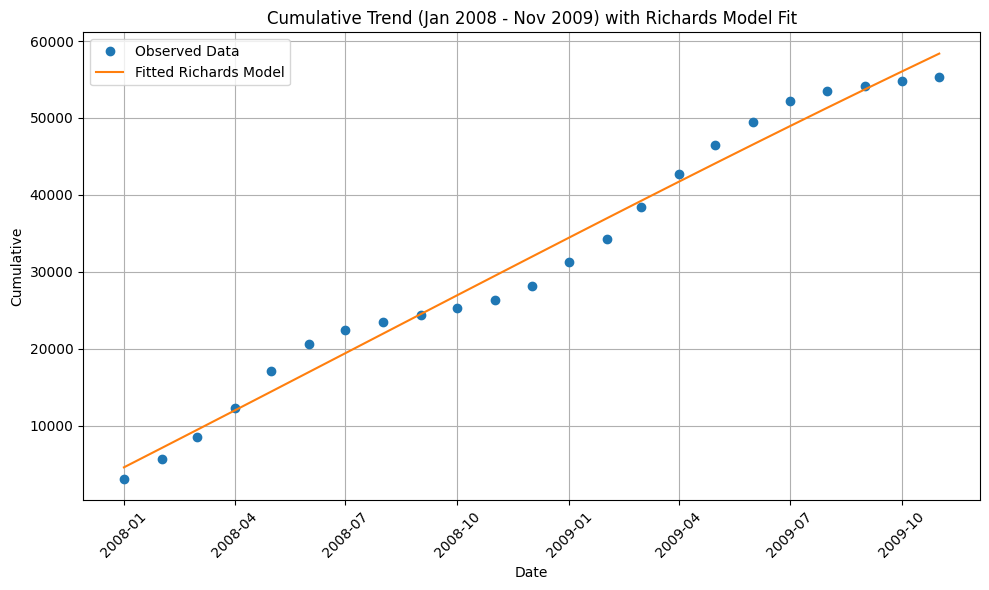

Fitted Parameters:
a (initial population): -111660.47146931189
b (growth rate): 1.2776006504026831
c (carrying capacity): 153074.12932526693
d (growth shape parameter): 0.0012390525135196296


In [ ]:
# prompt: fit the last column data from date january 2008 to november 2009 to the richards modification of the logistic model to model growth of biological populations



# Replace 'your_file.xlsx' with the actual path to your Excel file
df = pd.read_excel('DBD.xlsx')

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2009
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2009-11-30')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Extract x (time) and y (cumulative) data
x_data = (filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values
y_data = filtered_df['cumulative'].values

# Define the Richards modification of the logistic model
def richards_model(t, a, b, c, d):
  """
  Richards model for population growth.

  Args:
    t: Time (independent variable).
    a: Initial population size.
    b: Growth rate.
    c: Carrying capacity.
    d: Growth shape parameter.

  Returns:
    The predicted population size at time t.
  """
  return a + (c - a) * (1 + (b * np.exp(-d * t))) ** (-1)

# Fit the model to the data
try:
  popt, _ = curve_fit(richards_model, x_data, y_data,
                      p0=[y_data[0], 1, np.max(y_data), 0.1],
                      maxfev=10000)  # Initial guess for parameters

  # Extract the fitted parameters
  a, b, c, d = popt

  # Generate predicted values for plotting
  x_fit = np.linspace(x_data.min(), x_data.max(), 100)
  y_fit = richards_model(x_fit, a, b, c, d)

  # Plot the data and the fitted curve
  plt.figure(figsize=(10, 6))
  plt.plot(filtered_df['Date'], y_data, 'o', label='Observed Data')
  plt.plot(filtered_df['Date'], richards_model(x_data, a, b, c, d), '-', label='Fitted Richards Model')

  plt.xlabel('Date')
  plt.ylabel('Cumulative')
  plt.title('Cumulative Trend (Jan 2008 - Nov 2009) with Richards Model Fit')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  print("Fitted Parameters:")
  print("a (initial population):", a)
  print("b (growth rate):", b)
  print("c (carrying capacity):", c)
  print("d (growth shape parameter):", d)

except RuntimeError:
  print("Optimal parameters not found. Curve fitting may have failed.")

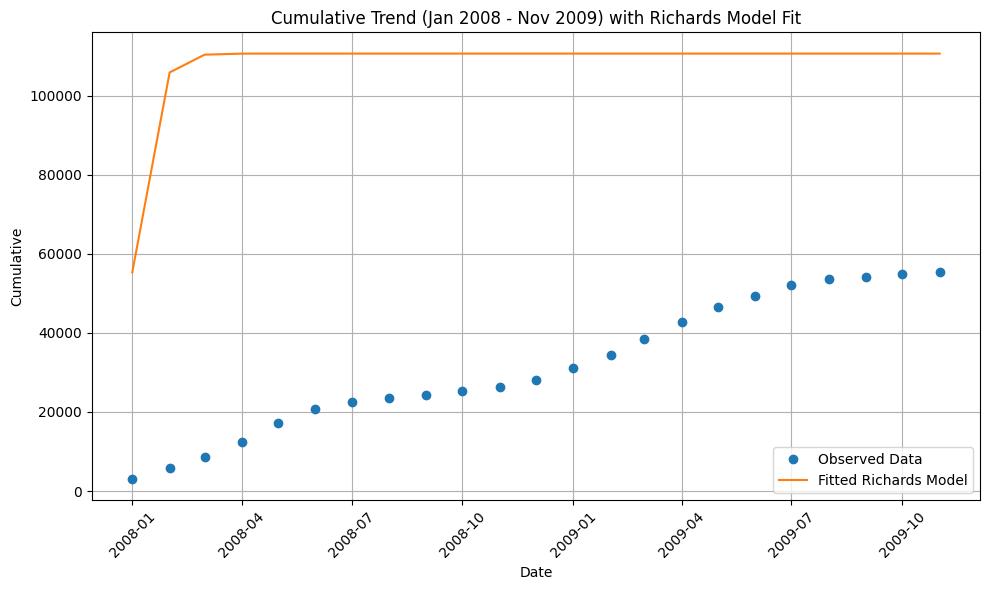

Fitted Parameters:
a1 (initial population): 0.0011511840720569797
b1 (growth rate): 1.0000404426246703
c1 (carrying capacity): 55314.3599677798
d1 (growth shape parameter): 0.09998705499598856
a2 (initial population): 0.0011511840720579963
b2 (growth rate): 1.0000404426246703
c2 (carrying capacity): 55314.3599677798
d2 (growth shape parameter): 0.09998705499598856


In [ ]:
# prompt: modifikasi kode diatas dengan tambahan syarat a1, a2, b1, b2, c1, c2, d1, d2 > 0

# Replace 'your_file.xlsx' with the actual path to your Excel file
df = pd.read_excel('DBD.xlsx')

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the period January 2008 to November 2009
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2009-11-30')
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Extract x (time) and y (cumulative) data
x_data = (filtered_df['Date'] - filtered_df['Date'].min()).dt.days.values
y_data = filtered_df['cumulative'].values

# Define the Richards modification of the logistic model
def richards_model(t, a1, b1, c1, d1, a2, b2, c2, d2):
  """
  Richards model for population growth.

  Args:
    t: Time (independent variable).
    a1, a2: Initial population size.
    b1, b2: Growth rate.
    c1, c2: Carrying capacity.
    d1, d2: Growth shape parameter.

  Returns:
    The predicted population size at time t.
  """
  if a1 <= 0 or b1 <= 0 or c1 <= 0 or d1 <= 0 or a2 <= 0 or b2 <= 0 or c2 <= 0 or d2 <= 0:
    return np.inf  # Or any other appropriate value to indicate an invalid fit

  return a1 + (c1 - a1) * (1 + (b1 * np.exp(-d1 * t))) ** (-1) + a2 + (c2 - a2) * (1 + (b2 * np.exp(-d2 * t))) ** (-1)

# Fit the model to the data
try:
  popt, _ = curve_fit(richards_model, x_data, y_data,
                      p0=[1, 1, np.max(y_data), 0.1, 1, 1, np.max(y_data), 0.1],
                      maxfev=10000)  # Initial guess for parameters

  # Extract the fitted parameters
  a1, b1, c1, d1, a2, b2, c2, d2 = popt

  # Generate predicted values for plotting
  x_fit = np.linspace(x_data.min(), x_data.max(), 100)
  y_fit = richards_model(x_fit, a1, b1, c1, d1, a2, b2, c2, d2)

  # Plot the data and the fitted curve
  plt.figure(figsize=(10, 6))
  plt.plot(filtered_df['Date'], y_data, 'o', label='Observed Data')
  plt.plot(filtered_df['Date'], richards_model(x_data, a1, b1, c1, d1, a2, b2, c2, d2), '-', label='Fitted Richards Model')

  plt.xlabel('Date')
  plt.ylabel('Cumulative')
  plt.title('Cumulative Trend (Jan 2008 - Nov 2009) with Richards Model Fit')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  print("Fitted Parameters:")
  print("a1 (initial population):", a1)
  print("b1 (growth rate):", b1)
  print("c1 (carrying capacity):", c1)
  print("d1 (growth shape parameter):", d1)
  print("a2 (initial population):", a2)
  print("b2 (growth rate):", b2)
  print("c2 (carrying capacity):", c2)
  print("d2 (growth shape parameter):", d2)

except RuntimeError:
  print("Optimal parameters not found. Curve fitting may have failed.")